In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from utilities import (find_missing_values, find_outliers)

In [2]:
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.figsize'] = (10, 6)
colors=["#ca0020", "#f4a582", "#92c5de", "#0571b0"]
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(colors))

In [3]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
find_missing_values(df)

,Zeroes,Empty Strings,NaN
fixed acidity,0,0,0
volatile acidity,0,0,0
citric acid,132,0,0
residual sugar,0,0,0
chlorides,0,0,0
free sulfur dioxide,0,0,0
total sulfur dioxide,0,0,0
density,0,0,0
pH,0,0,0
sulphates,0,0,0


In [5]:
df[df["citric acid"]==0]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.0,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.0,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
4,7.4,0.700,0.0,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
5,7.4,0.660,0.0,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
7,7.3,0.650,0.0,1.2,0.065,15.0,21.0,0.99460,3.39,0.47,10.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6.5,0.900,0.0,1.6,0.052,9.0,17.0,0.99467,3.50,0.63,10.9,6
1461,6.2,0.785,0.0,2.1,0.060,6.0,13.0,0.99664,3.59,0.61,10.0,4
1550,7.1,0.680,0.0,2.3,0.087,17.0,26.0,0.99783,3.45,0.53,9.5,5
1551,7.1,0.670,0.0,2.3,0.083,18.0,27.0,0.99768,3.44,0.54,9.4,5


In [6]:
print(f"There are {df.duplicated().sum()} duplicate rows.")

There are 240 duplicate rows.


In [7]:
df = df[~df.duplicated()]

In [8]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [9]:
# df = df.astype({"quality": "category"})

In [10]:
numeric = [feature for feature in df if df[feature].dtype in ["int64","float64"]]
outliers = find_outliers(df,numeric)
print(f"Outliers:\n{outliers}")

Outliers in 'fixed acidity':
205     12.8
243     15.0
264     12.5
294     13.3
328     13.4
338     12.4
339     12.5
347     13.8
353     13.5
359     12.6
363     12.5
364     12.8
374     14.0
381     13.7
394     12.7
409     12.5
429     12.8
440     12.6
442     15.6
446     12.5
470     13.0
472     12.5
509     13.3
510     12.4
516     12.5
538     12.9
544     14.3
548     12.4
554     15.5
557     15.6
559     13.0
560     12.7
596     12.4
599     12.7
601     13.2
611     13.2
652     15.9
680     13.3
811     12.9
814     12.6
1224    12.6
Name: fixed acidity, dtype: float64

Outliers in 'volatile acidity':
38      1.130
94      1.020
120     1.070
126     1.330
127     1.330
134     1.040
199     1.090
553     1.040
672     1.240
690     1.185
700     1.020
705     1.035
710     1.025
724     1.115
899     1.020
1261    1.020
1299    1.580
1312    1.180
1467    1.040
Name: volatile acidity, dtype: float64

Outliers in 'citric acid':
151    1.0
Name: citric acid, dtype:

<Axes: >

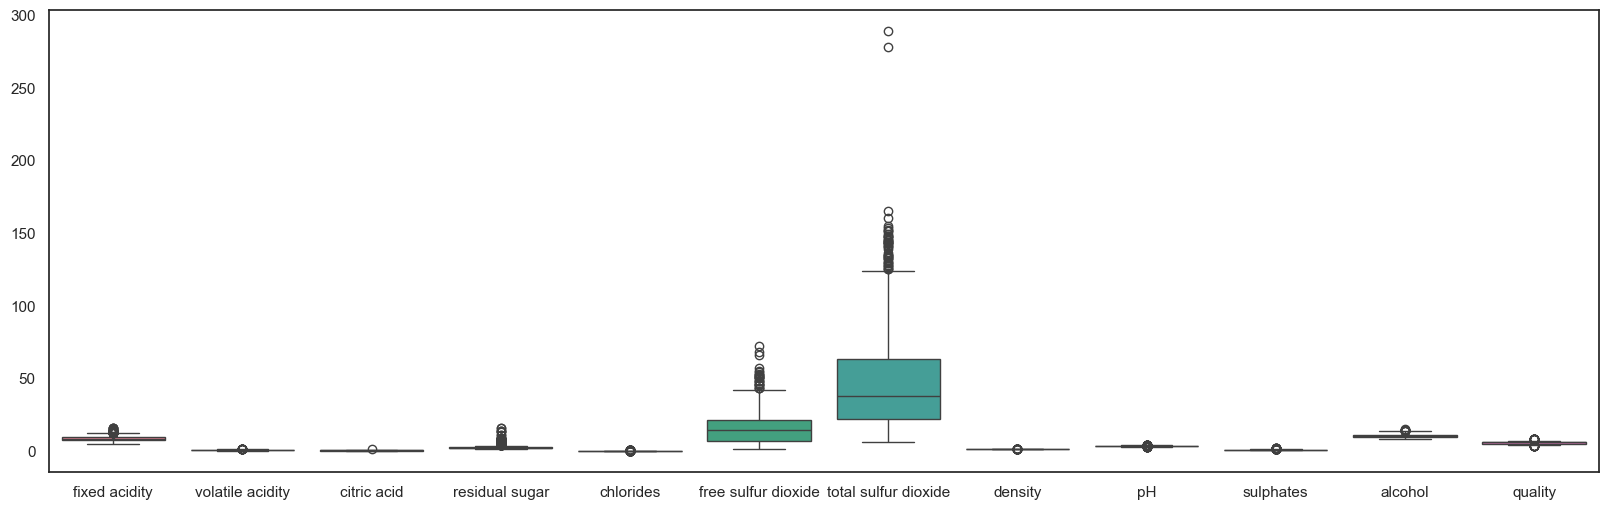

In [11]:
plt.figure(figsize=(20,6))
sns.boxplot(data=df)

In [12]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


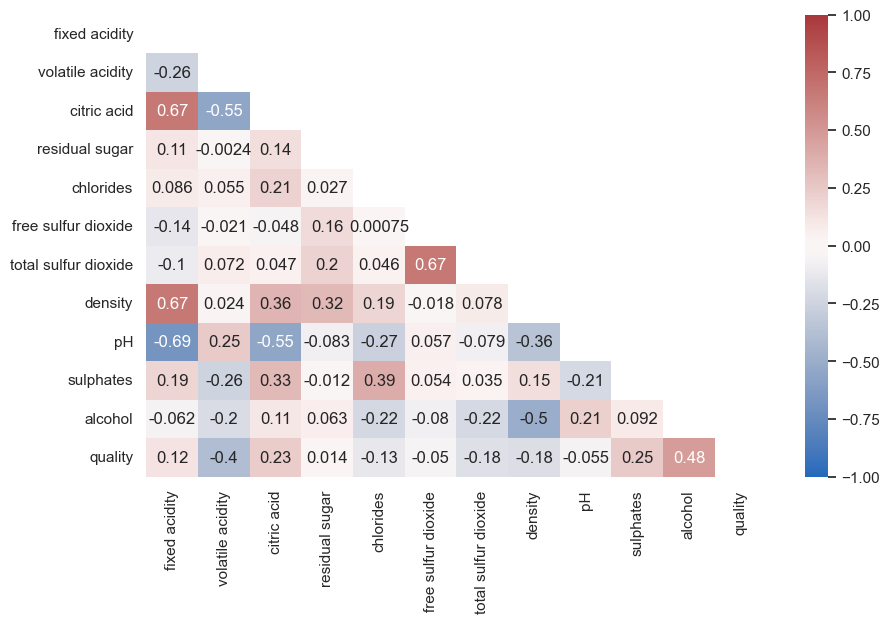

In [13]:
correlation = df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(data=correlation, mask=mask, vmax=1, vmin=-1, cmap="vlag", annot=True)
plt.show()

#### Positive:
- alchocol - quality (0.48)
- density - fixed acidity (0.67)
- total sulfur dioxide - free sulfur dioxide (0.67)
- fixed acidity - citric acid (0.67)

#### Negative:
- citric acid - volatile acidity (-0.55)
- ph - fixed acidity (-0.69)
- ph - citric acid (-0.55)

<Axes: xlabel='quality', ylabel='Count'>

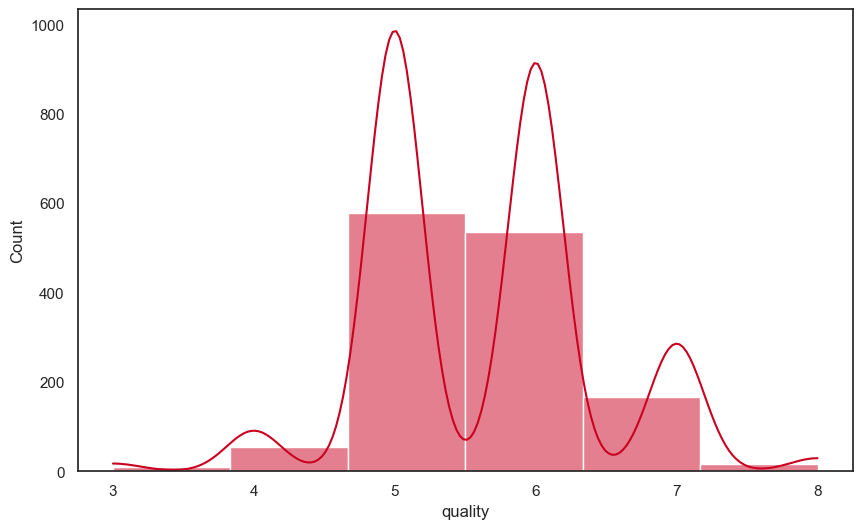

In [14]:
sns.histplot(df, x="quality", kde=True, bins=6)

In [15]:
correlation = df.corr()
print(correlation['density'])
print(correlation['fixed acidity'])

fixed acidity           0.670195
volatile acidity        0.023943
citric acid             0.357962
residual sugar          0.324522
chlorides               0.193592
free sulfur dioxide    -0.018071
total sulfur dioxide    0.078141
density                 1.000000
pH                     -0.355617
sulphates               0.146036
alcohol                -0.504995
quality                -0.184252
Name: density, dtype: float64
fixed acidity           1.000000
volatile acidity       -0.255124
citric acid             0.667437
residual sugar          0.111025
chlorides               0.085886
free sulfur dioxide    -0.140580
total sulfur dioxide   -0.103777
density                 0.670195
pH                     -0.686685
sulphates               0.190269
alcohol                -0.061596
quality                 0.119024
Name: fixed acidity, dtype: float64


In [16]:
X = df.drop(columns=["quality"])
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["VIF"] = vif_data["VIF"].apply(lambda x: f"{x:.2f}")
print(vif_data)

                 Feature         VIF
0                  const  1728334.01
1          fixed acidity        7.88
2       volatile acidity        1.78
3            citric acid        3.12
4         residual sugar        1.64
5              chlorides        1.53
6    free sulfur dioxide        1.95
7   total sulfur dioxide        2.22
8                density        6.28
9                     pH        3.40
10             sulphates        1.47
11               alcohol        3.14


In [17]:
X_reduced = X.drop(columns=["density"])

vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
vif_data_reduced["VIF"] = vif_data_reduced["VIF"].apply(lambda x: f"{x:.2f}")
print(vif_data_reduced)

                 Feature      VIF
0                  const  1450.52
1          fixed acidity     2.99
2       volatile acidity     1.76
3            citric acid     3.12
4         residual sugar     1.10
5              chlorides     1.51
6    free sulfur dioxide     1.94
7   total sulfur dioxide     2.20
8                     pH     2.31
9              sulphates     1.38
10               alcohol     1.32


**H0 (Null Hypothesis):** Alcohol levels do not influence wine quality.

**Ha (Alternative Hypothesis):** Higher levels of alcohol positively influence wine quality.

**α = 0.05 (5%)**